In [56]:
import numpy as np 
import pandas as pd 
import ccxt 
from tqdm.auto import tqdm 
from datetime import timedelta
import pandas_ta as ta
import seaborn as sns
from xgboost import XGBClassifier # modeling

In [4]:
df = pd.read_csv("minute_data.csv") 

In [34]:
open_val = df["open"].values 
high_val = df["high"].values 
low_val = df["low"].values 
close_val = df["close"].values  
volume_val = df["volume"].values 


open_values = [] 
high_values = [] 
low_values = [] 
close_values = [] 
volume_values = [] 
datetime_values = [] 

for i in tqdm(range(df.shape[0]), position=0, leave=True): 
    chart_df = df.iloc[i:i+180] 
    open_values.append(chart_df["open"].values[0]) 
    low_values.append(np.min(chart_df["low"].values)) 
    high_values.append(np.max(chart_df["high"].values)) 
    close_values.append(chart_df["close"].values[-1]) 
    volume_values.append(np.sum(chart_df["volume"].values)) 
    datetime_values.append(chart_df["datetime"].values[0]) 
    
temp_df = pd.DataFrame(list(zip(open_values, high_values, low_values, close_values, volume_values, datetime_values)), 
                  columns=["open", "high", "low", "close", "volume", "datetime"]) 

temp_df

  0%|          | 0/2705171 [00:00<?, ?it/s]

,open,high,low,close,volume,datetime
0,4261.48,4345.45,4261.32,4324.35,77.645616,2017-08-17 04:00:00
1,4261.48,4345.45,4261.32,4324.35,75.870433,2017-08-17 04:01:00
2,4280.56,4345.45,4261.32,4324.35,75.870433,2017-08-17 04:02:00
3,4261.48,4345.45,4261.32,4324.35,75.609359,2017-08-17 04:03:00
4,4261.48,4345.45,4261.32,4324.35,75.597351,2017-08-17 04:04:00
...,...,...,...,...,...,...
2705166,19349.76,19375.00,19340.11,19368.16,1113.713500,2022-10-14 16:38:00
2705167,19352.52,19375.00,19340.11,19368.16,805.680590,2022-10-14 16:39:00
2705168,19348.91,19375.00,19340.11,19368.16,631.715140,2022-10-14 16:40:00
2705169,19353.45,19375.00,19345.27,19368.16,426.444730,2022-10-14 16:41:00


In [36]:
targets_arr = []
threshold = 0.007 # 0.7% 
for i in tqdm(range(temp_df.shape[0])):
    dt = pd.to_datetime(temp_df["datetime"].values[i])  
    target_dt = dt + timedelta(hours=4) 
    if target_dt in datetime_table.keys(): 
        info = datetime_table[target_dt] 
        high_val = info["high"]  
        low_val = info["low"]
        close = temp_df["close"].values[i] 
        high_volatility = (high_val - close) / close 
        low_volatility = (low_val - close) / close 
        if high_volatility >= threshold: 
            targets_arr.append(0) 
        elif low_volatility <= -threshold: 
            targets_arr.append(1) 
        else: 
            targets_arr.append(2) 
        

  0%|          | 0/2705171 [00:00<?, ?it/s]

In [37]:
while len(targets_arr) < temp_df.shape[0]: 
    targets_arr.append(None) 

In [38]:
temp_df["Targets"] = targets_arr 

In [39]:
temp_df

,open,high,low,close,volume,datetime,Targets
0,4261.48,4345.45,4261.32,4324.35,77.645616,2017-08-17 04:00:00,0.0
1,4261.48,4345.45,4261.32,4324.35,75.870433,2017-08-17 04:01:00,0.0
2,4280.56,4345.45,4261.32,4324.35,75.870433,2017-08-17 04:02:00,0.0
3,4261.48,4345.45,4261.32,4324.35,75.609359,2017-08-17 04:03:00,0.0
4,4261.48,4345.45,4261.32,4324.35,75.597351,2017-08-17 04:04:00,0.0
...,...,...,...,...,...,...,...
2705166,19349.76,19375.00,19340.11,19368.16,1113.713500,2022-10-14 16:38:00,NaN
2705167,19352.52,19375.00,19340.11,19368.16,805.680590,2022-10-14 16:39:00,NaN
2705168,19348.91,19375.00,19340.11,19368.16,631.715140,2022-10-14 16:40:00,NaN
2705169,19353.45,19375.00,19345.27,19368.16,426.444730,2022-10-14 16:41:00,NaN


In [91]:
datetime_table = {}  

for i in tqdm(range(temp_df.shape[0])): 
    dt = pd.to_datetime(temp_df["datetime"].values[i]) 
    datetime_table[dt] = temp_df.iloc[i] 

  0%|          | 0/2700006 [00:00<?, ?it/s]

In [61]:
temp_df.dropna(inplace=True)

In [62]:
temp_df.to_csv("minute_with_targets.csv",index=False)

<AxesSubplot:xlabel='Targets', ylabel='count'>

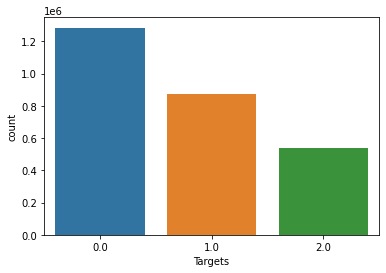

In [63]:
sns.countplot(data=temp_df, x="Targets")

In [104]:
def process_chart_data(chart_df):
    chart_df.set_index(pd.DatetimeIndex(chart_df["datetime"]), inplace=True)
    ### addition of chart features ### 
    chart_df["bop"] = chart_df.ta.bop(lookahead=False) 
    chart_df["ebsw"] = chart_df.ta.ebsw(lookahead=False) 
    chart_df["cmf"] = chart_df.ta.cmf(lookahead=False) 
    chart_df["rsi/100"] = chart_df.ta.rsi(lookahead=False) / 100
    chart_df["high/low"] = chart_df["high"] / chart_df["low"] 
    chart_df["close/open"] = chart_df["close"] / chart_df["open"] 
    chart_df["high/open"] = chart_df["high"] / chart_df["open"] 
    chart_df["low/open"] = chart_df["low"] / chart_df["open"] 
    chart_df["hwma"] = chart_df.ta.hwma(lookahead=False) 
    chart_df["linreg"] = chart_df.ta.linreg(lookahead=False) 
    chart_df["hwma/close"] = chart_df["hwma"] / chart_df["close"] 
    chart_df["linreg/close"] = chart_df["linreg"] / chart_df["close"] 

    ### addition of recent differenced features ### 
    for l in range(1, 12): 
        for col in ["high", "low", "volume"]:
            val = chart_df[col].values 
            val_ret = [None for _ in range(l)]
            for i in range(l, len(val)):
                if val[i-l] == 0: 
                    ret = 1 
                else:
                    ret = val[i] / val[i-l]  
                val_ret.append(ret) 
            chart_df["{}_change_{}".format(col, l)] = val_ret

    ### drop unnecessary columns ### 
    chart_df.drop(columns={"open","high","low","close","volume","linreg","hwma","datetime"}, inplace=True) 
    chart_df.dropna(inplace=True)
    return chart_df

In [107]:
latest_date = pd.to_datetime(temp_df["datetime"].values[-1]) 

full_dfs = [] 

for i in tqdm(range(temp_df.shape[0]), position=0, leave=True):
    cur_chart_df = temp_df.iloc[i,:]   
    dt = cur_chart_df["datetime"]
    dt = pd.to_datetime(dt) 
    df_list = [cur_chart_df] 
    while dt <= latest_date: 
        dt = dt + timedelta(hours=4) 
        if dt in datetime_table.keys(): 
            df_list.append(datetime_table[dt])
    cur_df = pd.concat(df_list, axis=1).T 
    cur_df = process_chart_data(cur_df) 
    full_dfs.append(cur_df) 
    if i==100: 
        break
    

  0%|          | 0/2700006 [00:00<?, ?it/s]

In [111]:
for i in range(100): 

,Targets,bop,ebsw,cmf,rsi/100,high/low,close/open,high/open,low/open,hwma/close,...,volume_change_8,high_change_9,low_change_9,volume_change_9,high_change_10,low_change_10,volume_change_10,high_change_11,low_change_11,volume_change_11
datetime,,,,,,,,,,,,,,,,,,,,,
2017-08-23 17:40:00,0.0,-0.448284,0.000000,0.210732,0.525568,1.033027,0.985565,1.007209,0.975008,0.993172,...,0.546292,1.092099,1.198491,0.645669,1.088115,1.114747,2.011037,1.034138,1.029759,1.345857
2017-08-23 21:40:00,0.0,0.178261,0.577350,0.208724,0.533421,1.024618,1.00434,1.013358,0.989011,0.996427,...,0.959005,1.059855,1.063689,0.548092,1.081861,1.197000,0.647796,1.077915,1.113360,2.017661
2017-08-24 01:40:00,0.0,-0.126485,0.796990,0.239333,0.537576,1.029263,0.996361,1.011925,0.983155,1.001036,...,0.860160,1.070953,1.078747,0.943847,1.068639,1.067664,0.539429,1.090827,1.201474,0.637557
2017-08-24 05:40:00,0.0,0.581995,0.983904,0.330057,0.575980,1.017931,1.010358,1.010358,0.99256,0.994285,...,0.997979,1.024649,1.050276,0.822637,1.071322,1.091132,0.902673,1.069008,1.079922,0.515897
2017-08-24 09:40:00,0.0,-0.351715,0.987390,0.236042,0.534602,1.027708,0.990377,1.014765,0.987405,1.01297,...,1.086660,1.042618,1.048757,1.500462,1.035597,1.051399,1.236835,1.082769,1.092299,1.357169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-10 09:40:00,0.0,0.830084,-0.853489,-0.022446,0.431873,1.007591,1.0063,1.00738,0.999791,0.979341,...,2.026247,0.997453,1.001149,1.094233,0.994472,0.991569,2.479148,0.993646,0.991978,1.660373
2022-10-10 13:40:00,2.0,-0.348607,-0.982282,-0.077278,0.384767,1.015621,0.994622,1.003116,0.987688,0.985316,...,3.749075,0.999055,0.988723,3.939230,0.996995,0.992778,2.127299,0.994016,0.983278,4.819715
2022-10-10 17:40:00,1.0,-0.081471,-0.987222,-0.090868,0.385544,1.008956,0.999273,1.005759,0.996831,0.984006,...,1.637777,0.995828,0.990268,2.394520,0.997109,0.993315,2.515971,0.995053,0.997389,1.358698
